<a href="https://colab.research.google.com/github/goldsmithklein/1/blob/main/AKTA_993298FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data from /content/drive/MyDrive/AKTA raw/20251014-993298_FL_sec.xls...
Found 18 columns in the data file
Absorbance (mAu) range: -0.448 to 511.395
Volume (ml1) range: 0.0 to 179.8381432467926
Conductivity range: 13.076 to 15.56
Loaded 900 data points successfully
Main peak detected: 511.39 mAU at 58.81 ml

=== PEAK 1 ANALYSIS ===
Peak 1 - Selected 14 data points in fraction range 54.13-67.13 ml
Peak 1 - Selected 8 data points in concentration range 57.13-64.13 ml

=== FRACTION INFORMATION ===
Volume vs. Fraction Number:
----------------------------
Volume: 44.14 ml - Fraction: 46 
Volume: 45.14 ml - Fraction: 47 
Volume: 46.14 ml - Fraction: 48 
Volume: 47.14 ml - Fraction: 49 
Volume: 48.14 ml - Fraction: 50 
Volume: 49.14 ml - Fraction: 51 
Volume: 50.14 ml - Fraction: 52 
Volume: 51.14 ml - Fraction: 53 
Volume: 52.14 ml - Fraction: 54 
Volume: 53.14 ml - Fraction: 55 
Volume: 54.13 ml - Fraction: 56 * PEAK 1 *
Volume: 55.13 ml - Fraction: 57 * PEAK 1 *
Volume: 56.13 ml - F

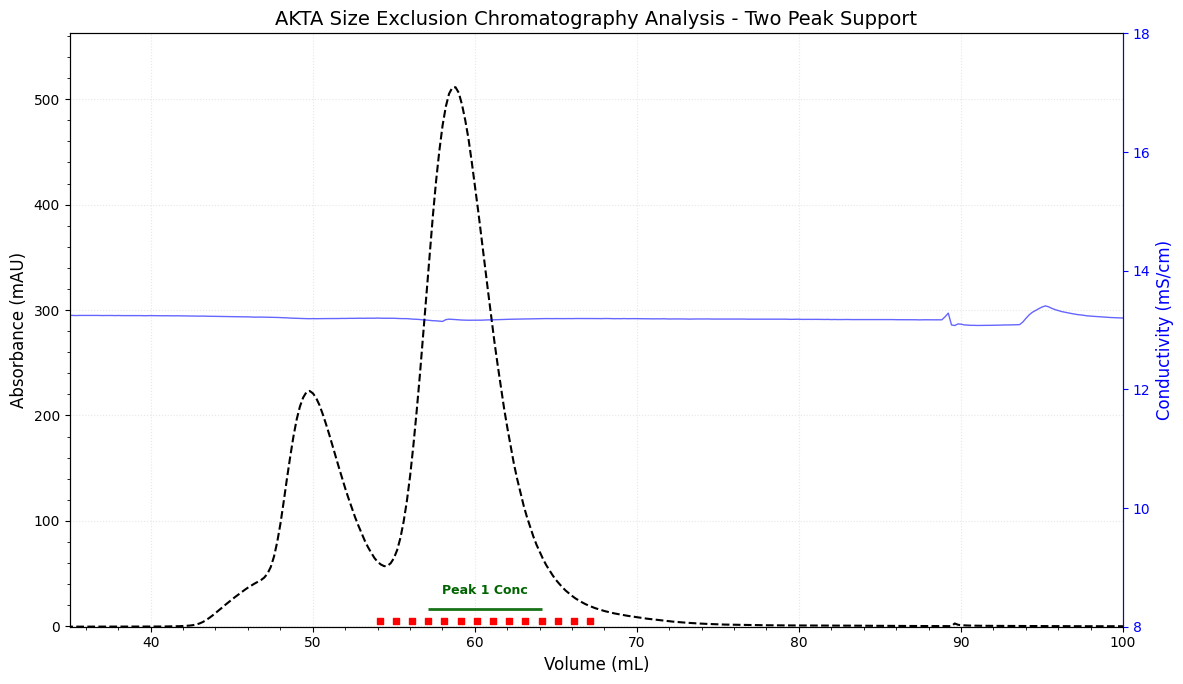

In [17]:
# ==============================================================================
# AKTA Size Exclusion Chromatography (SEC) Data Analysis Tool - Two Peak Version
# ==============================================================================
#
# This script analyzes and visualizes Size Exclusion Chromatography data from
# AKTA FPLC systems. It processes Excel (.xls) files containing chromatographic
# data and generates publication-ready plots with customizable fraction
# collection and concentration ranges for TWO SEPARATE PEAKS.
#
# Features:
# - Reads AKTA XLS data files with configurable column mapping
# - Plots UV absorbance (280nm) chromatograms with optional conductivity overlay
# - Marks fraction collection ranges and concentrated fractions for TWO peaks
# - Identifies and reports main peaks with elution volumes
# - Exports high-resolution plots with transparent backgrounds
# - Provides detailed fraction analysis and statistics for both peaks
#
# Input Data Requirements:
# - Excel file from AKTA system with standard column structure
# - Columns should include: Volume (mL), Absorbance (mAU), Conductivity (mS/cm)
# - Optional fraction data with volume and fraction number information
#
# Output:
# - Console output with peak analysis and fraction statistics
# - High-resolution chromatogram plot (PNG format)
# - Optional CSV export of processed data
#
# Author: Scone Leen
# Date: May 2025
# Version: 2.1 - Two Peak Support
#
# Usage:
# 1. Modify the configuration parameters below
# 2. Set the correct file path to your AKTA data
# 3. Adjust fraction and concentration ranges for both peaks as needed
# 4. Run the script to generate analysis and plots
#
# ==============================================================================
# CONFIGURATION SECTION - MODIFY THESE VALUES AS NEEDED
# ==============================================================================

# File path to your XLS data file
FILE_PATH = '/content/drive/MyDrive/AKTA raw/20251014-993298_FL_sec.xls'

# ============= PEAK 1 CONFIGURATION =============
# Fraction collection range for Peak 1 (in mL)
PEAK1_FRACTION_START = 54.13
PEAK1_FRACTION_END = 67.13

# Concentrated fractions range for Peak 1 (subset of fractions to be concentrated)
PEAK1_CONCENTRATE_START = 57.13   # Starting point for concentration
PEAK1_CONCENTRATE_END = 64.13      # Ending point for concentration

# ============= PEAK 2 CONFIGURATION =============
# Fraction collection range for Peak 2 (in mL)
PEAK2_FRACTION_START = 54.13      # Example values - adjust as needed
PEAK2_FRACTION_END = 66.13

# Concentrated fractions range for Peak 2 (subset of fractions to be concentrated)
PEAK2_CONCENTRATE_START = 57.13   # Starting point for concentration
PEAK2_CONCENTRATE_END = 64.13     # Ending point for concentration

# ============= GENERAL CONFIGURATION =============
# Display range on the x-axis (in mL)
X_AXIS_MIN = 35
X_AXIS_MAX = 100

# Y-axis limits for conductivity (mS/cm)
CONDUCTIVITY_Y_MIN = 8      # Minimum value for conductivity Y-axis
CONDUCTIVITY_Y_MAX = 18     # Maximum value for conductivity Y-axis (set to None for auto)

# Direct column indices for your specific AKTA file format
# These are 0-based indices (first column = 0)
VOLUME_COLUMN = 0        # ml (volume) column
ABSORBANCE_COLUMN = 1    # mAu (absorbance) column
CONDUCTIVITY_COLUMN = 3  # mS/cm (conductivity) column
FRACTION_VOL_COLUMN = 12  # ml for fractions
FRACTION_NUM_COLUMN = 13  # Fraction numbers

# Other settings
SHOW_CONDUCTIVITY = True      # Show conductivity trace
SAVE_OUTPUT = True            # Save plot to file
OUTPUT_PATH = './sec_plot.png'  # Where to save the plot
SHOW_LEGEND = False           # Whether to display the legend
SHOW_FRACTION_LABEL = False   # Whether to show the fraction range label
SHOW_CONCENTRATION = True     # Whether to show concentrated fractions
SHOW_PEAK2 = False           # Whether to process and show Peak 2 data
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
import os
import warnings

def analyze_sec_data(file_path, config=None):
    """
    Analyze Size Exclusion Chromatography data from AKTA and create visualization
    with support for two separate peaks.

    Args:
        file_path (str): Path to the XLS file
        config (dict, optional): Configuration parameters for analysis and visualization

    Returns:
        tuple: (DataFrame, dict) - Processed data and analysis results
    """
    # Default configuration
    default_config = {
        'header_row': 2,  # Using row 2 (third row) which usually has ml, mAu etc.
        'peak1_fraction_range': (PEAK1_FRACTION_START, PEAK1_FRACTION_END),
        'peak1_concentrate_range': (PEAK1_CONCENTRATE_START, PEAK1_CONCENTRATE_END),
        'peak2_fraction_range': (PEAK2_FRACTION_START, PEAK2_FRACTION_END),
        'peak2_concentrate_range': (PEAK2_CONCENTRATE_START, PEAK2_CONCENTRATE_END),
        'x_axis_limits': (X_AXIS_MIN, X_AXIS_MAX),
        'conductivity_y_limits': (CONDUCTIVITY_Y_MIN, CONDUCTIVITY_Y_MAX),
        'show_conductivity': SHOW_CONDUCTIVITY,
        'save_output': SAVE_OUTPUT,
        'output_path': OUTPUT_PATH,
        'volume_column': VOLUME_COLUMN,
        'absorbance_column': ABSORBANCE_COLUMN,
        'conductivity_column': CONDUCTIVITY_COLUMN,
        'fraction_vol_column': FRACTION_VOL_COLUMN,
        'fraction_num_column': FRACTION_NUM_COLUMN,
        'show_legend': SHOW_LEGEND,
        'show_fraction_label': SHOW_FRACTION_LABEL,
        'show_concentration': SHOW_CONCENTRATION,
        'show_peak2': SHOW_PEAK2
    }

    # Use default config updated with provided config
    if config is None:
        config = {}
    conf = {**default_config, **config}

    # Verify input file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Input file not found: {file_path}")

    # Load data from file
    print(f"Loading data from {file_path}...")
    try:
        # First, read in the raw data
        warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
        df_raw = pd.read_excel(file_path, header=conf['header_row'])

        # Print some information about the file
        print(f"Found {len(df_raw.columns)} columns in the data file")

        # Create a new DataFrame for our analysis
        df = pd.DataFrame()

        # Extract data using the specified column indices
        # Main volume and absorbance data
        df['ml1'] = pd.to_numeric(df_raw.iloc[:, conf['volume_column']], errors='coerce')
        df['mAu'] = pd.to_numeric(df_raw.iloc[:, conf['absorbance_column']], errors='coerce')

        # Get conductivity data
        cond_col = conf['conductivity_column']
        cond_vol_col = conf['volume_column'] + 2  # Usually volume column for conductivity
        if cond_col < len(df_raw.columns):
            df['ml2'] = pd.to_numeric(df_raw.iloc[:, cond_vol_col], errors='coerce')
            df['mS/cm'] = pd.to_numeric(df_raw.iloc[:, cond_col], errors='coerce')
        else:
            df['ml2'] = df['ml1']
            df['mS/cm'] = 0
            conf['show_conductivity'] = False

        # Get fraction data
        frac_vol_col = conf['fraction_vol_column']
        frac_num_col = conf['fraction_num_column']

        if frac_vol_col < len(df_raw.columns):
            df['ml4'] = pd.to_numeric(df_raw.iloc[:, frac_vol_col], errors='coerce')
            if frac_num_col < len(df_raw.columns):
                df['Fractions'] = df_raw.iloc[:, frac_num_col].astype(str)
            else:
                df['Fractions'] = ""
        else:
            df['ml4'] = df['ml1']
            df['Fractions'] = ""

        # Clean the data
        df = df.dropna(subset=['ml1', 'mAu'])

        # Print data ranges for verification
        print(f"Absorbance (mAu) range: {df['mAu'].min()} to {df['mAu'].max()}")
        print(f"Volume (ml1) range: {df['ml1'].min()} to {df['ml1'].max()}")
        if conf['show_conductivity']:
            print(f"Conductivity range: {df['mS/cm'].min()} to {df['mS/cm'].max()}")

        print(f"Loaded {len(df)} data points successfully")

    except Exception as e:
        raise RuntimeError(f"Error reading data file: {e}")

    # Analyze data
    results = {}

    # Find the main peak
    if len(df) > 0:
        max_absorbance = df['mAu'].max()
        max_absorbance_idx = df['mAu'].idxmax()
        max_absorbance_vol = df.loc[max_absorbance_idx, 'ml1']
        results['max_absorbance'] = {
            'value': max_absorbance,
            'volume': max_absorbance_vol
        }
        print(f"Main peak detected: {max_absorbance:.2f} mAU at {max_absorbance_vol:.2f} ml")
    else:
        print("No valid data points found!")
        return None, None, None

    # Process Peak 1 data
    print("\n=== PEAK 1 ANALYSIS ===")
    peak1_fraction_start, peak1_fraction_end = conf['peak1_fraction_range']
    peak1_fractions_df = df[(df['ml4'] >= peak1_fraction_start) & (df['ml4'] <= peak1_fraction_end)]
    results['peak1_fractions'] = {
        'range': conf['peak1_fraction_range'],
        'count': len(peak1_fractions_df)
    }
    print(f"Peak 1 - Selected {len(peak1_fractions_df)} data points in fraction range {peak1_fraction_start:.2f}-{peak1_fraction_end:.2f} ml")

    # Filter for Peak 1 concentrated fractions
    peak1_concentrate_start, peak1_concentrate_end = conf['peak1_concentrate_range']
    peak1_concentrate_df = df[(df['ml4'] >= peak1_concentrate_start) & (df['ml4'] <= peak1_concentrate_end)]
    results['peak1_concentrate'] = {
        'range': conf['peak1_concentrate_range'],
        'count': len(peak1_concentrate_df)
    }
    print(f"Peak 1 - Selected {len(peak1_concentrate_df)} data points in concentration range {peak1_concentrate_start:.2f}-{peak1_concentrate_end:.2f} ml")

    # Process Peak 2 data (if enabled)
    peak2_fractions_df = pd.DataFrame()
    peak2_concentrate_df = pd.DataFrame()

    if conf['show_peak2']:
        print("\n=== PEAK 2 ANALYSIS ===")
        peak2_fraction_start, peak2_fraction_end = conf['peak2_fraction_range']
        peak2_fractions_df = df[(df['ml4'] >= peak2_fraction_start) & (df['ml4'] <= peak2_fraction_end)]
        results['peak2_fractions'] = {
            'range': conf['peak2_fraction_range'],
            'count': len(peak2_fractions_df)
        }
        print(f"Peak 2 - Selected {len(peak2_fractions_df)} data points in fraction range {peak2_fraction_start:.2f}-{peak2_fraction_end:.2f} ml")

        # Filter for Peak 2 concentrated fractions
        peak2_concentrate_start, peak2_concentrate_end = conf['peak2_concentrate_range']
        peak2_concentrate_df = df[(df['ml4'] >= peak2_concentrate_start) & (df['ml4'] <= peak2_concentrate_end)]
        results['peak2_concentrate'] = {
            'range': conf['peak2_concentrate_range'],
            'count': len(peak2_concentrate_df)
        }
        print(f"Peak 2 - Selected {len(peak2_concentrate_df)} data points in concentration range {peak2_concentrate_start:.2f}-{peak2_concentrate_end:.2f} ml")

    # Extract fraction information for console display
    fraction_rows = df[df['Fractions'].str.strip() != ''].copy()

    # Clean fraction numbers - try to extract numeric part
    def extract_number(val):
        try:
            if pd.isna(val) or val == '':
                return ''
            # Try to find numeric part
            import re
            match = re.search(r'(\d+)', str(val))
            if match:
                return match.group(1)
            return str(val)
        except:
            return str(val)

    fraction_rows['FractionNum'] = fraction_rows['Fractions'].apply(extract_number)

    # Print fraction information for both peaks
    if len(fraction_rows) > 0:
        print("\n=== FRACTION INFORMATION ===")
        print("Volume vs. Fraction Number:")
        print("----------------------------")

        # Get the full range to display (from earliest peak start to latest peak end)
        all_starts = [peak1_fraction_start]
        all_ends = [peak1_fraction_end]

        if conf['show_peak2']:
            all_starts.append(peak2_fraction_start)
            all_ends.append(peak2_fraction_end)

        display_start = min(all_starts) - 10
        display_end = max(all_ends) + 10

        # Filter to fractions near our ranges
        display_fractions = fraction_rows[
            (fraction_rows['ml4'] >= display_start) &
            (fraction_rows['ml4'] <= display_end)
        ].sort_values(by='ml4')

        for _, row in display_fractions.iterrows():
            # Check if this fraction is concentrated in either peak
            peak1_concentrated = (row['ml4'] >= peak1_concentrate_start) and (row['ml4'] <= peak1_concentrate_end)
            peak2_concentrated = False
            if conf['show_peak2']:
                peak2_concentrated = (row['ml4'] >= peak2_concentrate_start) and (row['ml4'] <= peak2_concentrate_end)

            # Determine which peak this fraction belongs to
            peak1_fraction = (row['ml4'] >= peak1_fraction_start) and (row['ml4'] <= peak1_fraction_end)
            peak2_fraction = False
            if conf['show_peak2']:
                peak2_fraction = (row['ml4'] >= peak2_fraction_start) and (row['ml4'] <= peak2_fraction_end)

            # Create status indicators
            status_parts = []
            if peak1_fraction:
                status_parts.append("PEAK 1")
            if peak2_fraction:
                status_parts.append("PEAK 2")
            if peak1_concentrated:
                status_parts.append("CONC-1")
            if peak2_concentrated:
                status_parts.append("CONC-2")

            status = " | ".join(status_parts) if status_parts else ""
            if status:
                status = f"* {status} *"

            print(f"Volume: {row['ml4']:.2f} ml - Fraction: {row['FractionNum']} {status}")
    else:
        print("\nNo fraction information found in the data")

    # Create visualization
    fig, ax1 = create_plot(df, peak1_fractions_df, peak1_concentrate_df,
                          peak2_fractions_df, peak2_concentrate_df, conf, results)

    # Save if requested
    if conf['save_output']:
        plt.savefig(conf['output_path'], dpi=300, bbox_inches='tight', transparent=True)
        print(f"Plot saved to {conf['output_path']}")

    # Return processed data and results
    return df, results, fig

def create_plot(df, peak1_fractions_df, peak1_concentrate_df,
               peak2_fractions_df, peak2_concentrate_df, conf, results):
    """
    Create visualization of SEC data with support for two peaks

    Args:
        df (DataFrame): Full SEC data
        peak1_fractions_df (DataFrame): Filtered data for Peak 1 fraction range
        peak1_concentrate_df (DataFrame): Filtered data for Peak 1 concentration range
        peak2_fractions_df (DataFrame): Filtered data for Peak 2 fraction range
        peak2_concentrate_df (DataFrame): Filtered data for Peak 2 concentration range
        conf (dict): Configuration parameters
        results (dict): Analysis results

    Returns:
        tuple: (Figure, Axis) - Matplotlib figure and primary axis
    """
    # Set font properties
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot mL versus mAU with black dashed line
    ax1.plot(df['ml1'], df['mAu'], linestyle='--', linewidth=1.5,
             color='black', label='UV 280nm')

    # Calculate appropriate y-axis limits
    # Include some padding (10%) above the maximum absorbance
    y_max = df['mAu'].max() * 1.1
    y_min = min(0, df['mAu'].min())  # Include negative values if present
    ax1.set_ylim(y_min, y_max)

    # Add conductivity on secondary axis if enabled
    if conf['show_conductivity']:
        ax2 = ax1.twinx()
        ax2.plot(df['ml2'], df['mS/cm'], color='blue', alpha=0.6,
                 linestyle='-', linewidth=1, label='Conductivity')
        ax2.set_ylabel('Conductivity (mS/cm)', color='blue')
        ax2.tick_params(axis='y', colors='blue')
        ax2.spines['right'].set_color('blue')

        # SET CONDUCTIVITY Y-AXIS LIMITS
        cond_y_min, cond_y_max = conf['conductivity_y_limits']
        if cond_y_max is not None:  # If max is specified
            if cond_y_min is not None:  # If both min and max are specified
                ax2.set_ylim(cond_y_min, cond_y_max)
            else:  # If only max is specified, auto-calculate min
                ax2.set_ylim(bottom=0, top=cond_y_max)
        elif cond_y_min is not None:  # If only min is specified
            ax2.set_ylim(bottom=cond_y_min)

    # Calculate marker positions
    marker_y_pos = y_min + (y_max - y_min) * 0.01  # Just slightly above bottom

    # Plot Peak 1 fractions as red squares
    if len(peak1_fractions_df) > 0:
        ax1.scatter(peak1_fractions_df['ml4'], [marker_y_pos]*len(peak1_fractions_df),
                    marker='s', color='red', s=15, label='Peak 1 Fractions', zorder=3)

    # Plot Peak 2 fractions as blue triangles (if enabled)
    if conf['show_peak2'] and len(peak2_fractions_df) > 0:
        ax1.scatter(peak2_fractions_df['ml4'], [marker_y_pos]*len(peak2_fractions_df),
                    marker='^', color='blue', s=15, label='Peak 2 Fractions', zorder=3)

    # Add concentration indicators
    if conf['show_concentration']:
        line_y_pos = y_min + (y_max - y_min) * 0.03  # Above the fraction markers
        text_y_pos = line_y_pos + (y_max - y_min) * 0.02

        # Peak 1 concentrated fractions (dark green)
        if len(peak1_concentrate_df) > 0:
            peak1_concentrate_start, peak1_concentrate_end = conf['peak1_concentrate_range']
            dark_green = '#006400'  # Dark green color

            ax1.plot([peak1_concentrate_start, peak1_concentrate_end], [line_y_pos, line_y_pos],
                     color=dark_green, linewidth=2, alpha=0.9, solid_capstyle='butt', zorder=4)

            ax1.text((peak1_concentrate_start + peak1_concentrate_end)/2, text_y_pos,
                    'Peak 1 Conc', ha='center', va='bottom', color=dark_green,
                    fontsize=9, fontweight='bold')

        # Peak 2 concentrated fractions (dark purple)
        if conf['show_peak2'] and len(peak2_concentrate_df) > 0:
            peak2_concentrate_start, peak2_concentrate_end = conf['peak2_concentrate_range']
            dark_purple = '#4B0082'  # Dark purple color

            # Offset the line slightly to avoid overlap
            line_y_pos_2 = line_y_pos + (y_max - y_min) * 0.01
            text_y_pos_2 = line_y_pos_2 + (y_max - y_min) * 0.02

            ax1.plot([peak2_concentrate_start, peak2_concentrate_end], [line_y_pos_2, line_y_pos_2],
                     color=dark_purple, linewidth=2, alpha=0.9, solid_capstyle='butt', zorder=4)

            ax1.text((peak2_concentrate_start + peak2_concentrate_end)/2, text_y_pos_2,
                    'Peak 2 Conc', ha='center', va='bottom', color=dark_purple,
                    fontsize=9, fontweight='bold')

    # Set the x-axis limits
    ax1.set_xlim(conf['x_axis_limits'])

    # Format plot appearance
    ax1.set_facecolor('none')    # Transparent background
    fig.patch.set_alpha(0.0)     # Transparent figure
    ax1.grid(False)              # Remove grid lines by default

    # Add minor ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())

    # Add light grid
    ax1.grid(True, linestyle=':', alpha=0.3)

    # Update axis labels and title
    plt.title('AKTA Size Exclusion Chromatography Analysis - Two Peak Support')
    ax1.set_xlabel('Volume (mL)')
    ax1.set_ylabel('Absorbance (mAU)', color='black')

    # Create legend if requested
    if conf['show_legend']:
        if conf['show_conductivity']:
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

    plt.tight_layout()
    return fig, ax1

# Example usage
if __name__ == "__main__":
    try:
        df, results, fig = analyze_sec_data(FILE_PATH)
        if fig is not None:
            plt.show()
    except Exception as e:
        print(f"Error: {e}")

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
